In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.linalg as LINA
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score
%matplotlib inline

plt.rc("figure", facecolor="white")

params = {
    'lines.markersize' : 10,
    'axes.labelsize': 20,
    'font.size': 20,
    'legend.fontsize': 20,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20,
    'text.usetex': False,
   }
plt.rcParams.update(params)
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]   

# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.    
for i in range(len(tableau20)):    
    r, g, b = tableau20[i]    
    tableau20[i] = (r / 255., g / 255., b / 255.)   


In [2]:
#load numpy data and Descripor list
data = np.loadtxt('../salty/data/salts_with_descriptors')
f = open('../salty/data/Deslist','r')
deslist = []
for line in f:
    deslist.append("Cation %s " % line.strip('\n\t'))
f = open('../salty/data/Deslist','r')
for line in f:
    deslist.append("Anion %s " % line.strip('\n\t'))
deslist.append("Temperature")
deslist.append("Pressure")
deslist.append("Density")

data = data[~np.isnan(data).any(axis=1)]

n = data.shape[0]
d = data.shape[1]
d -= 1
print(n,d)
print(len(deslist))

(3659, 190)
191


In [3]:
n_train = int(n*0.8)
n_test  = n - n_train
data = np.random.permutation(data)

X_train = np.zeros((n_train,d))
X_test  = np.zeros((n_test,d))
Y_train = np.zeros((n_train))
Y_test = np.zeros((n_test))

X_train[:] = data[:n_train,:-1]
Y_train[:] = np.log(data[:n_train,-1])

X_test[:] = data[n_train:,:-1]
Y_test[:] = np.log(data[n_train:,-1])

print(X_train.shape)
print(X_test.shape)

(2927, 190)
(732, 190)


In [12]:
model = Lasso(alpha=1e-2,tol=1e-10)
model.fit(X_train,Y_train)

Lasso(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=1e-10, warm_start=False)

In [13]:
i=0
for a in range(len(deslist)-1):
    if model.coef_[a] != 0:
        print(a, deslist[a])
        i+=1
print(i)

(97, 'Anion BertzCT ')
(98, 'Anion Ipc ')
(102, 'Anion Kappa3 ')
(117, 'Anion MolWt ')
(128, 'Anion TPSA ')
(158, 'Anion SlogP_VSA5 ')
(184, 'Anion VSA_EState8 ')
(185, 'Anion VSA_EState9 ')
(188, 'Temperature')
(189, 'Pressure')
10


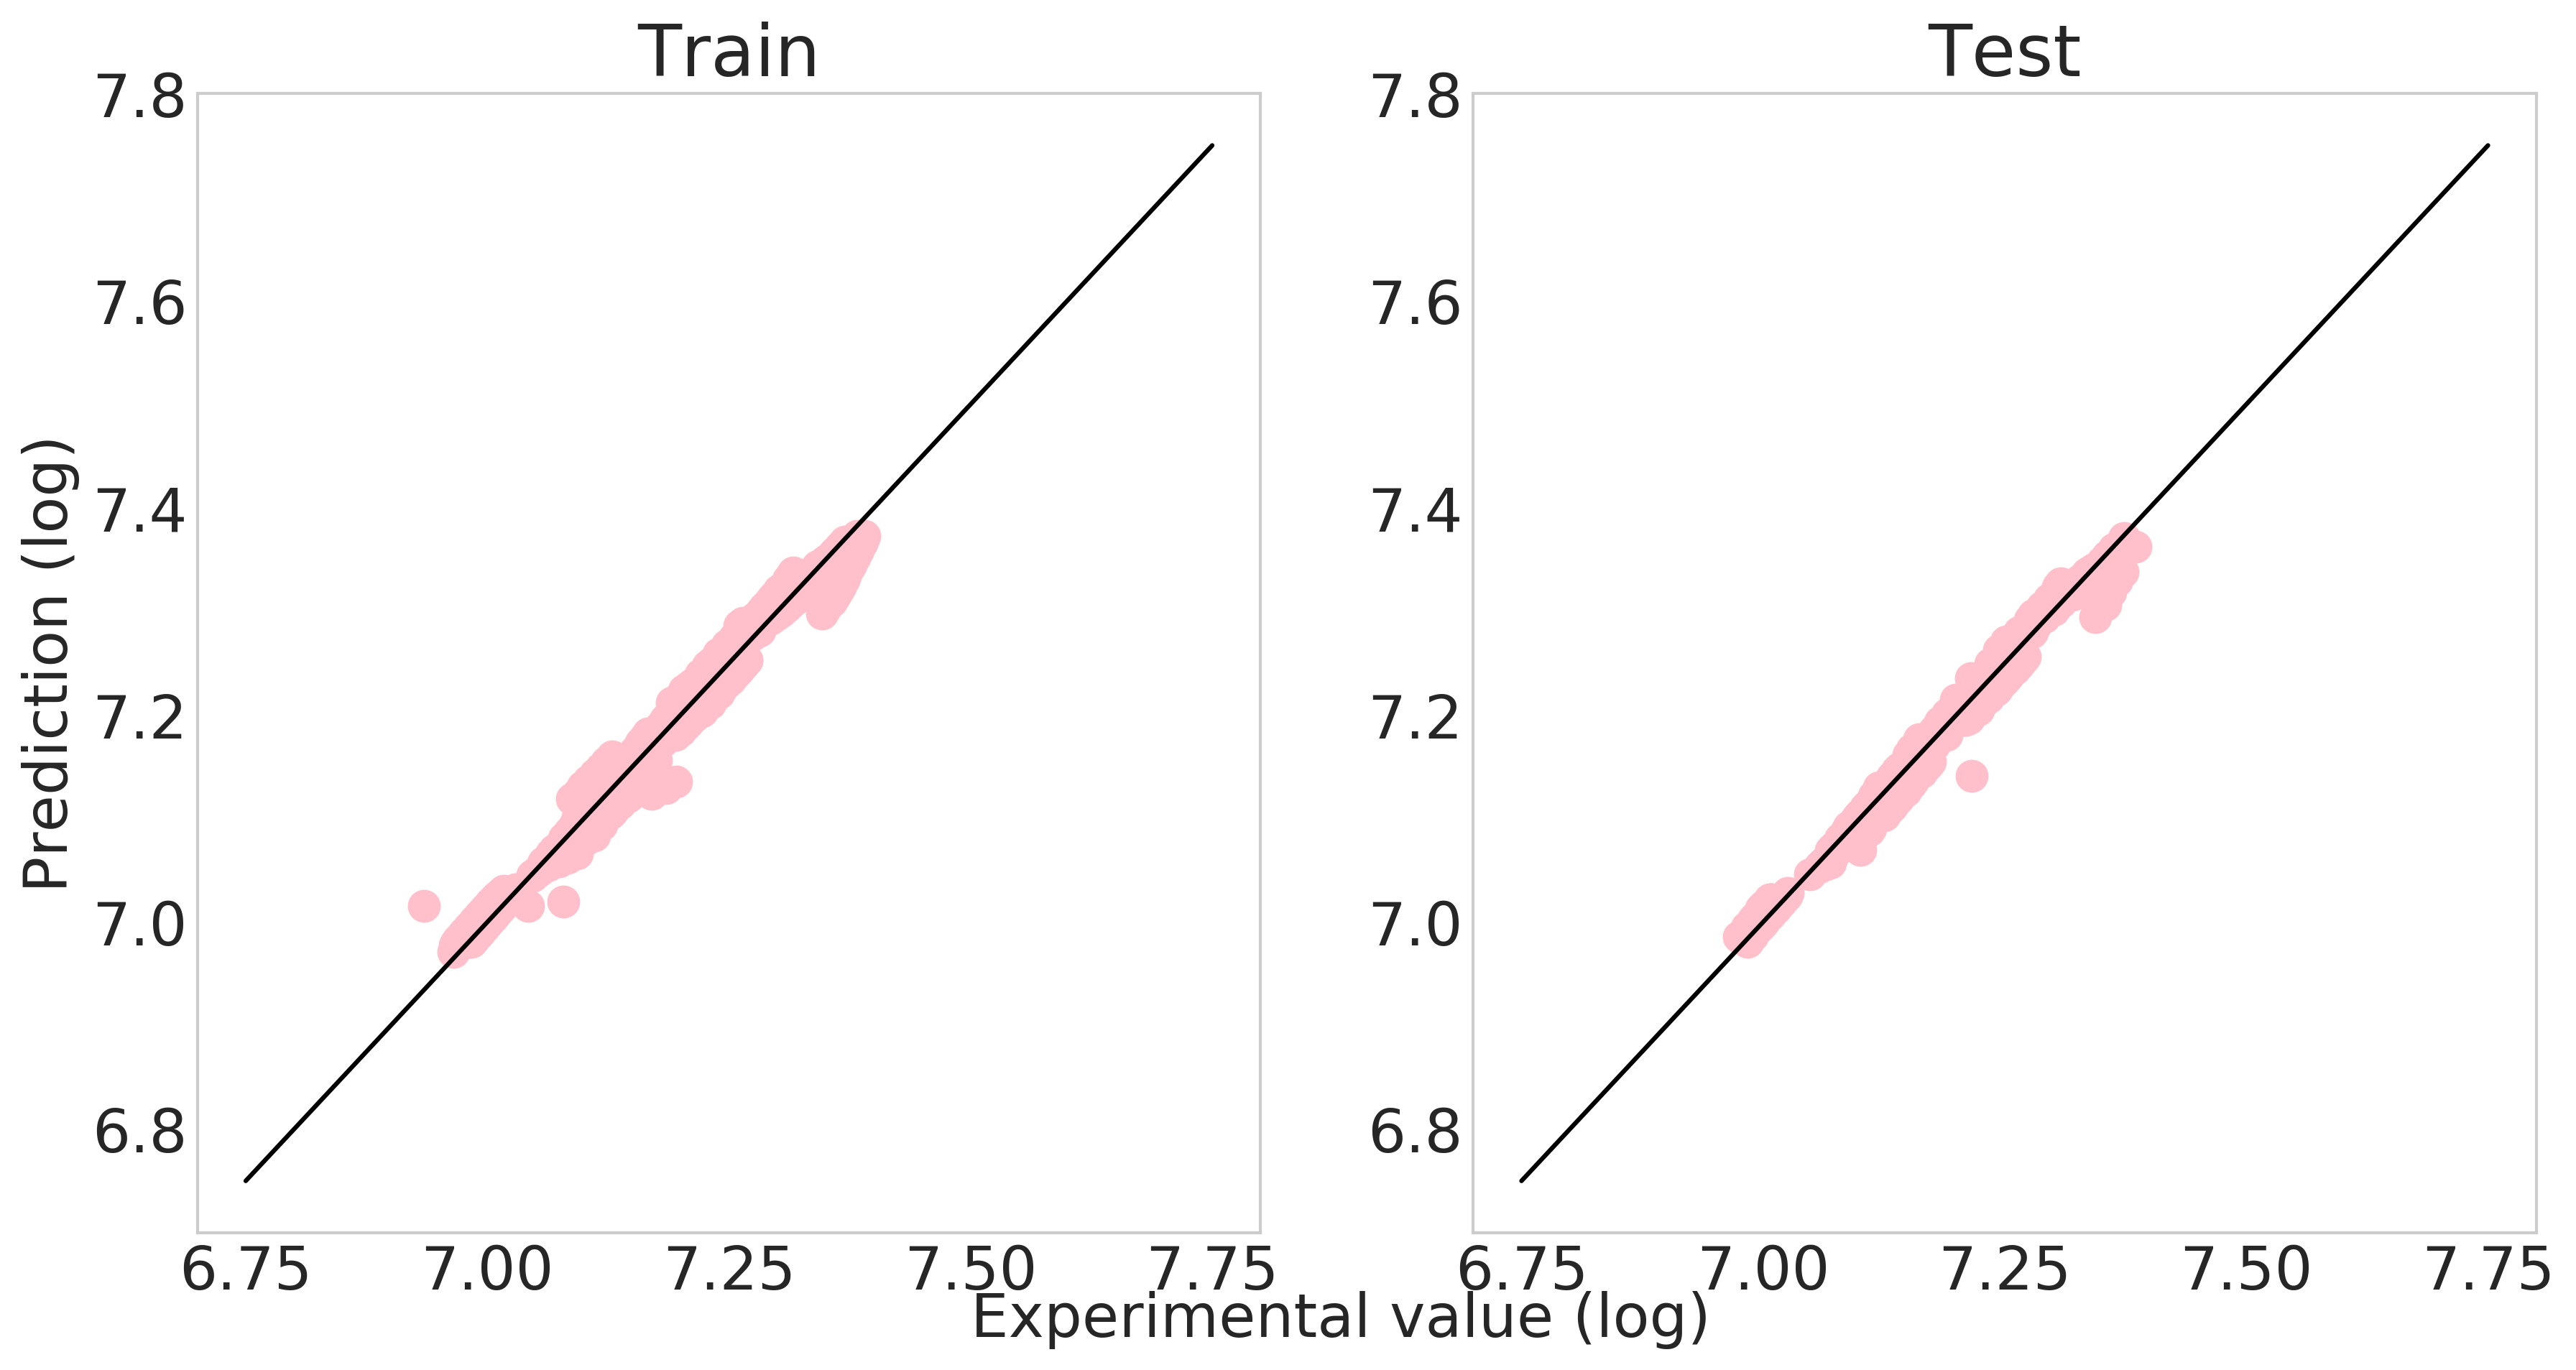

In [14]:
with plt.style.context('seaborn-whitegrid'):
    fig=plt.figure(figsize=(14,7), dpi=300)
    ax = fig.add_subplot(121)
    ax.plot(Y_train,model.predict(X_train),"o",color = "pink")
    ax.plot(np.arange(6.75,7.75,0.0001),np.arange(6.75,7.75,0.0001),color = 'black')
#     ax.axis([-6,1,-6,1])
#     plt.xlim(-6,-1)
#     plt.ylim(-6,-1)
    plt.text(7.5,6.6,'Experimental value (log)')
    plt.ylabel('Prediction (log)')
    plt.title('Train')
    plt.grid(False)
    ax2 = fig.add_subplot(122)
    ax2.plot(Y_test,model.predict(X_test),"o",color = "pink")
    ax2.plot(np.arange(6.75,7.75,0.0001),np.arange(6.75,7.75,0.0001),color = 'black')
#     ax2.axis([-6,1,-6,1])
#     plt.xlim(-6,-1)
#     plt.ylim(-6,-1)
    plt.title('Test')
    plt.grid(False)

In [20]:
###hyperparameters are lambda (alpha), bootstrap splitfraction (BSF), convergence critiera/allowance (tol)
###maximum number of bootstrap iterations (NBI)

def CVLasso(deslist, data, alpha_array=np.arange(1,0,-1e-2), wrapper=False, tol_lasso=1e-10):
    print('Job will perform %s tests for lambda' % len(alpha_array))
    
    
    n = data.shape[0]
    d = data.shape[1]
    d -= 1
    n_train = int(n*1) #set fraction of data to be for training
    n_test  = n - n_train

    data = np.random.permutation(data) #if you delete, will not be random ie separate by group
    X_train = np.zeros((n_train,d)) #prepare train/test arrays
    X_test  = np.zeros((n_test,d))
    Y_train = np.zeros((n_train))
    Y_test = np.zeros((n_test))
    X_train[:] = data[:n_train,:-1] #fill arrays according to train/test split
    Y_train[:] = np.log(data[:n_train,-1].astype(float))
    X_test[:] = data[n_train:,:-1]
    Y_test[:] = np.log(data[n_train:,-1].astype(float))
    averages=np.zeros(len(alpha_array))
    variances=np.zeros(len(alpha_array))

    for i in range(len(alpha_array)):
        ###Train the LASSO model
        model = Lasso(alpha=alpha_array[i],tol=tol_lasso)
        
        ###Calculate MSE
        scores = cross_val_score(model, X_train, Y_train, cv=5, scoring='neg_mean_squared_error')
        avg = np.average(scores)
        std = np.std(scores)
        averages[i] = avg
        variances[i] = std
        optimum_alpha=alpha_array[np.argmin(np.absolute(averages))]
        if wrapper==False:
            if (i+1/len(alpha_array)*10)%10 == 0:
                print("Job %s" % str(i+1/len(alpha_array)*10), r"% complete" )
       
   
    displayResult(alpha_array, averages, variances=variances, optimum_alpha=optimum_alpha, error=True)
    displayFeatures(optimum_alpha, tol_lasso, X_train, Y_train, data, deslist)
    print('Job complete')
    return averages, variances, alpha_array

def displayFeatures(optimum_lambda, tol_lasso, X_train, Y_train, data, deslist):
    model = Lasso(alpha=optimum_lambda,tol=tol_lasso)
    model.fit(X_train,Y_train)
    i=0
    for a in range(len(data[0])-1):
        if model.coef_[a] != 0:
            print(a,deslist[a])
            i+=1
    print("%s total features selected" % i)
    
def displayResult(alpha_array, averages, variances=None, optimum_alpha=None, error=False):
    with plt.style.context('seaborn-whitegrid'):
        plt.figure(figsize=(14,14))
        if error==False:
            plt.plot(np.log(alpha_array), averages)
        else:
            plt.errorbar(np.log(alpha_array), np.absolute(averages), np.absolute(variances))
            plt.plot(np.log(optimum_alpha), np.min(np.absolute(averages)), \
                c='r', marker='*', markersize=20, label=optimum_alpha)
        plt.legend()
        plt.ylabel('average MSE')
        plt.xlabel('lambda')
        plt.grid(False)
        plt.show()

def myround(x, base):
    return (float(base) * round(float(x)/float(base)))

def CVWrapper(name_of_pickle, iterations=30, TSF=0.8, BSF=0.8, alpha_array=np.arange(1,0,-1e-2),\
                    invisible_test=False):
    """
    wrapper for boostrapLassoInvisibleTest. TSF is the test split fraction, the 
    test MSE dataset that the bootstrap will not sample from for a given iteration.
    """
    datadf = pd.read_pickle(name_of_pickle)
    data=np.array(datadf)
    results=np.zeros((len(alpha_array),iterations))
    for i in range(iterations):
        if invisible_test:
            dataRand = np.random.permutation(data)
            n = data.shape[0]
            n_train = int(n*TSF) #set fraction of data to be for training
            result, returned_alpha_array = bootstrapLassoInvisibleTest(datadf, dataRand[:n_train,:],dataRand[n_train:,:],\
                    alpha_array=alpha_array, BSF=BSF, wrapper=True)
        else:
            print("this is working")
            result, returned_alpha_array = bootstrapLasso(datadf, data,\
                    alpha_array=alpha_array, BSF=BSF, wrapper=True)
        results[:,i]=result

    avg = np.mean(results, axis=1)
    std = np.std(results,ddof=1,axis=1)
    return avg, std, results

Job will perform 11 tests for lambda
('Job 0', '% complete')
('Job 10', '% complete')

/home/wesley/anaconda3/envs/py27/lib/python2.7/site-packages/IPython/kernel/__main__.py:63: RuntimeWarning: invalid value encountered in log
/home/wesley/anaconda3/envs/py27/lib/python2.7/site-packages/IPython/kernel/__main__.py:64: RuntimeWarning: invalid value encountered in log


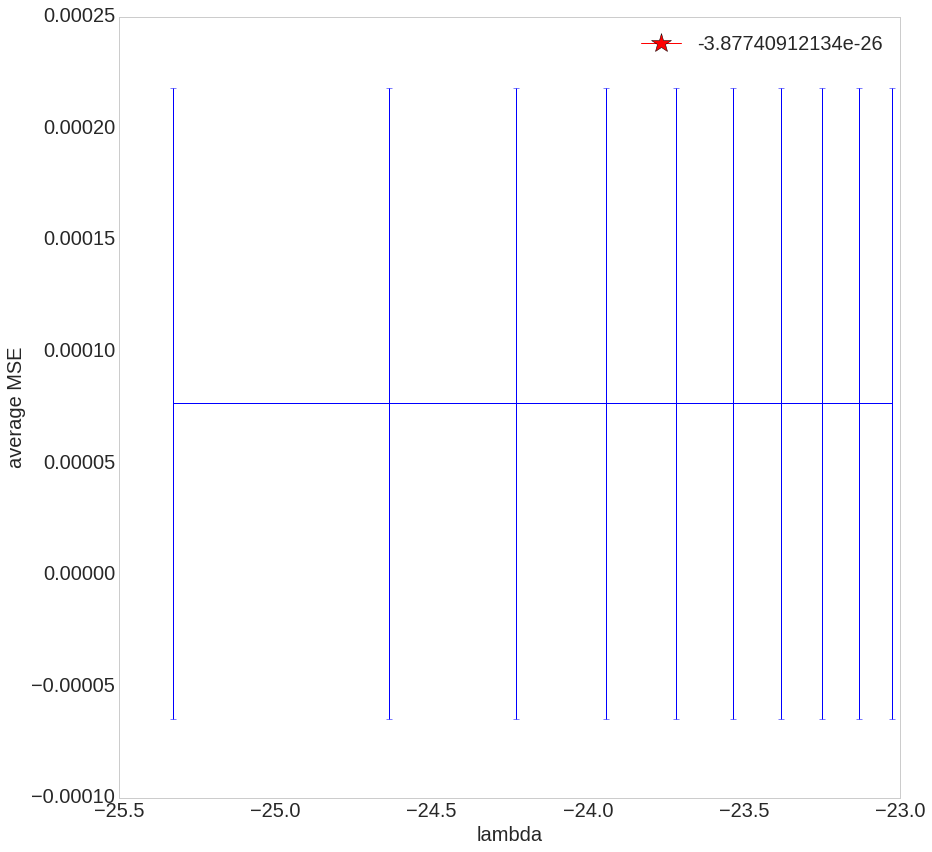

(4, 'Cation Ipc ')
(5, 'Cation HallKierAlpha ')
(6, 'Cation Kappa1 ')
(7, 'Cation Kappa2 ')
(8, 'Cation Kappa3 ')
(9, 'Cation Chi0 ')
(10, 'Cation Chi1 ')
(12, 'Cation Chi1n ')
(13, 'Cation Chi2n ')
(14, 'Cation Chi3n ')
(15, 'Cation Chi4n ')
(17, 'Cation Chi1v ')
(18, 'Cation Chi2v ')
(19, 'Cation Chi3v ')
(20, 'Cation Chi4v ')
(21, 'Cation MolLogP ')
(23, 'Cation MolWt ')
(25, 'Cation HeavyAtomMolWt ')
(34, 'Cation TPSA ')
(35, 'Cation LabuteASA ')
(38, 'Cation PEOE_VSA3 ')
(42, 'Cation PEOE_VSA7 ')
(44, 'Cation PEOE_VSA9 ')
(45, 'Cation PEOE_VSA10 ')
(47, 'Cation PEOE_VSA12 ')
(50, 'Cation SMR_VSA1 ')
(52, 'Cation SMR_VSA3 ')
(53, 'Cation SMR_VSA4 ')
(54, 'Cation SMR_VSA5 ')
(56, 'Cation SMR_VSA7 ')
(60, 'Cation SlogP_VSA1 ')
(61, 'Cation SlogP_VSA2 ')
(62, 'Cation SlogP_VSA3 ')
(64, 'Cation SlogP_VSA5 ')
(65, 'Cation SlogP_VSA6 ')
(75, 'Cation EState_VSA4 ')
(78, 'Cation EState_VSA7 ')
(79, 'Cation EState_VSA8 ')
(96, 'Anion BalabanJ ')
(97, 'Anion BertzCT ')
(98, 'Anion Ipc ')
(99

(array([ -7.67502411e-05,  -7.67502692e-05,  -7.67502972e-05,
         -7.67503252e-05,  -7.67503533e-05,  -7.67503813e-05,
         -7.67504093e-05,  -7.67504374e-05,  -7.67504654e-05,
         -7.67504935e-05,  -7.67502395e-05]),
 array([ 0.00014122,  0.00014122,  0.00014122,  0.00014122,  0.00014122,
         0.00014122,  0.00014122,  0.00014122,  0.00014122,  0.00014122,
         0.00014122]),
 array([  1.00000000e-10,   9.00000000e-11,   8.00000000e-11,
          7.00000000e-11,   6.00000000e-11,   5.00000000e-11,
          4.00000000e-11,   3.00000000e-11,   2.00000000e-11,
          1.00000000e-11,  -3.87740912e-26]))

In [56]:
CVLasso(deslist, data, alpha_array=np.arange(1e-10,0,-1e-11), wrapper=False, tol_lasso=1e-10)